In [1]:
import numpy as np
import pandas as pd


from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from psql_functions import execQuery
from miss_data import add_missing_dates, add_missing_counts
from make_plots import dict_error_plot_epsilons, dict_error_plot_n

import warnings
warnings.filterwarnings('ignore')

import sys
import os
import re
owd = os.getcwd()

In [2]:
param_dic = {
    "host"      : "localhost",
    "database"  : "bachelorBesoeg2014",
    "user"      : "postgres",
    "password"  : "password",
    "port"      : "5432"
}

query = """select time_ from _775147;"""
result = execQuery(param_dic, query)
dates = [(date[0]) for date in result]

query = """select count_ from _775147;"""
result = execQuery(param_dic, query)

counts = [(count[0]) for count in result]

all_dates = add_missing_dates(dates)
all_counts =  add_missing_counts(counts, dates, all_dates)

n_data_structures = 50


Executed query and closed connection.
Executed query and closed connection.


In [3]:
onlydirs = [f for f in os.listdir(os.getcwd()) if os.path.isdir(os.path.join(os.getcwd(), f)) and f[0] != '.']

In [4]:
onlydirs

['Data', 'plots', 'range_queries', 'results', '__pycache__']

In [5]:
def make_lookup_error_dict_e_n(epsilons, n):
    epsilon_dict = dict.fromkeys(epsilons)
    n_dicts = []
    for i in range(0,len(epsilons)):
        n_dict = dict.fromkeys(n)
        n_dicts.append(n_dict)

    i = 0
    for e_key in epsilon_dict:
        epsilon_dict[e_key] = n_dicts[i]
        i = i + 1
    return epsilon_dict

def make_query_lookup_dict_n_r(n, rs):
    n_dict = dict.fromkeys(n)
    r_dicts = []
    for i in range(0,len(n)):
        #print(rs[i])
        r_dict = dict.fromkeys(rs[i])
        r_dicts.append(r_dict)

    for idx, n_key in enumerate(n_dict):
            n_dict[n_key] = r_dicts[idx]
    
    return n_dict

def fill_up_query_lookup_dict_n_r(n, rs, files):
    dict_ = make_query_lookup_dict_n_r(n, rs)
    for idx, f in enumerate(files):
        here_n = re.search(r'N=\d+', f).group(0)
        here_n = here_n.split("N=")[1]
        here_r = re.search(r'r=\d+', f).group(0) 
        here_r = here_r.split("r=")[1]
        
        querries = load_range_queries_n_split(f, n_data_structures)
        dict_[int(here_n)][int(here_r)] = querries.copy()
    return dict_

In [6]:
def make_lookup_error_dict(epsilons, n, rs):
    epsilon_dict = dict.fromkeys(epsilons)
    n_dicts = []
    for i in range(0,len(epsilons)):
        n_dict = dict.fromkeys(n)
        n_dicts.append(n_dict)
    r_dicts = []
    for i in range(0,len(n)*len(epsilons)):
        r_dict = dict.fromkeys(rs[i%len(n)])
        r_dicts.append(r_dict)
    i = 0
    j = 0
    for e_key in epsilon_dict:
        epsilon_dict[e_key] = n_dicts[i]
        n_dict = epsilon_dict[e_key]
        for n_key in n_dict:
            #print(j)
            n_dict[n_key] = r_dicts[j]
            j = j + 1
        i = i + 1
    return epsilon_dict


def fill_up_lookup_error_dict(epsilons, n, degrees, files):
    dict_ = make_lookup_error_dict(epsilons, n, degrees)
    for idx, f in enumerate(files):
        print(f)
        e = re.search(r'e=[-+]?[0-9]*\.?[0-9]*', f).group(0)
        e = e.split("e=")[1]
        here_n = re.search(r'N=\d+', f).group(0)
        here_n = here_n.split("N=")[1]
        here_r = re.search(r'r=\d+', f).group(0) 
        here_r = here_r.split("r=")[1]

        dict_[float(e)][int(here_n)][int(here_r)] = np.loadtxt(f, delimiter=',')
    return dict_

def find_error_different_queries(est, cor):
    erorrs = est - cor
    max_error = np.amax(erorrs)
    min_error = np.amin(erorrs)
    rmse = mean_squared_error(cor, est, squared = False)
    error_dict = {'rmse': rmse, 'max': max_error, 'min': min_error, 'abs': np.mean(erorrs)}
    return error_dict

In [7]:
epsilons = np.array([2.0, 1.4, 1.2, 1, 0.8, 0.6, 0.4, 0.2])
n = np.array([32, 128, 256, 512, 1024, 2048])

flat_r_32 =  np.array([2, 4, 8, 12, 16, 20, 24])
flat_r_128 =  np.array([20, 40, 50, 60, 70, 80, 90])
flat_r_256 =  np.array([40, 60, 80, 100, 140, 200, 220])
flat_r_512 =  np.array([100, 150, 200, 250, 300, 400, 450])
flat_r_1024 =  np.array([200, 300, 400, 500, 600, 800, 900])
flat_r_2048 =  np.array([600, 800, 1000, 1250, 1500, 1700, 1800])

rs = [flat_r_32, flat_r_128, flat_r_256, flat_r_512, flat_r_1024, flat_r_2048]

In [8]:
len(epsilons)*len(n)*len(rs[0])

336

# Loading the data 

In [9]:

os.chdir(os.getcwd()+'/'+'results/sample_querys/flat_varying_r/')

In [10]:
path =  owd +'/'+'results/sample_querys/flat_varying_r/'
files = os.listdir(path)
files_cor = files[:len(files)//2]
files_est = files[len(files)//2:]
print(files_cor)
print(len(files_cor))

print(files_est)
print(len(files_est))
"""
#Where flat beats hh
hh_files_cor_flat = hh_files_cor[:144]
#Where hh beats flat
hh_files_cor_hh = hh_files_cor[144+1:]
#print(hh_files_cor_flat)
#print(hh_files_cor_hh)
hh_files_est = hh_files[len(hh_files)//2:]
hh_files_est_flat = hh_files_est[:144]
hh_files_est_hh = hh_files_est[144+1:]
#print(hh_files_est_flat)
#print(hh_files_est_hh)
"""

['cor_e=0.2_N=1024_r=200.csv', 'cor_e=0.2_N=1024_r=300.csv', 'cor_e=0.2_N=1024_r=400.csv', 'cor_e=0.2_N=1024_r=500.csv', 'cor_e=0.2_N=1024_r=600.csv', 'cor_e=0.2_N=1024_r=800.csv', 'cor_e=0.2_N=1024_r=900.csv', 'cor_e=0.2_N=128_r=20.csv', 'cor_e=0.2_N=128_r=40.csv', 'cor_e=0.2_N=128_r=50.csv', 'cor_e=0.2_N=128_r=60.csv', 'cor_e=0.2_N=128_r=70.csv', 'cor_e=0.2_N=128_r=80.csv', 'cor_e=0.2_N=128_r=90.csv', 'cor_e=0.2_N=2048_r=1000.csv', 'cor_e=0.2_N=2048_r=1250.csv', 'cor_e=0.2_N=2048_r=1500.csv', 'cor_e=0.2_N=2048_r=1700.csv', 'cor_e=0.2_N=2048_r=1800.csv', 'cor_e=0.2_N=2048_r=600.csv', 'cor_e=0.2_N=2048_r=800.csv', 'cor_e=0.2_N=256_r=100.csv', 'cor_e=0.2_N=256_r=140.csv', 'cor_e=0.2_N=256_r=200.csv', 'cor_e=0.2_N=256_r=220.csv', 'cor_e=0.2_N=256_r=40.csv', 'cor_e=0.2_N=256_r=60.csv', 'cor_e=0.2_N=256_r=80.csv', 'cor_e=0.2_N=32_r=12.csv', 'cor_e=0.2_N=32_r=16.csv', 'cor_e=0.2_N=32_r=2.csv', 'cor_e=0.2_N=32_r=20.csv', 'cor_e=0.2_N=32_r=24.csv', 'cor_e=0.2_N=32_r=4.csv', 'cor_e=0.2_N=32_r=

'\n#Where flat beats hh\nhh_files_cor_flat = hh_files_cor[:144]\n#Where hh beats flat\nhh_files_cor_hh = hh_files_cor[144+1:]\n#print(hh_files_cor_flat)\n#print(hh_files_cor_hh)\nhh_files_est = hh_files[len(hh_files)//2:]\nhh_files_est_flat = hh_files_est[:144]\nhh_files_est_hh = hh_files_est[144+1:]\n#print(hh_files_est_flat)\n#print(hh_files_est_hh)\n'

In [11]:
cor_dict = fill_up_lookup_error_dict(epsilons, n, rs, files_cor)
est_dict = fill_up_lookup_error_dict(epsilons, n, rs, files_est)


cor_e=0.2_N=1024_r=200.csv
cor_e=0.2_N=1024_r=300.csv
cor_e=0.2_N=1024_r=400.csv
cor_e=0.2_N=1024_r=500.csv
cor_e=0.2_N=1024_r=600.csv
cor_e=0.2_N=1024_r=800.csv
cor_e=0.2_N=1024_r=900.csv
cor_e=0.2_N=128_r=20.csv
cor_e=0.2_N=128_r=40.csv
cor_e=0.2_N=128_r=50.csv
cor_e=0.2_N=128_r=60.csv
cor_e=0.2_N=128_r=70.csv
cor_e=0.2_N=128_r=80.csv
cor_e=0.2_N=128_r=90.csv
cor_e=0.2_N=2048_r=1000.csv
cor_e=0.2_N=2048_r=1250.csv
cor_e=0.2_N=2048_r=1500.csv
cor_e=0.2_N=2048_r=1700.csv
cor_e=0.2_N=2048_r=1800.csv
cor_e=0.2_N=2048_r=600.csv
cor_e=0.2_N=2048_r=800.csv
cor_e=0.2_N=256_r=100.csv
cor_e=0.2_N=256_r=140.csv
cor_e=0.2_N=256_r=200.csv
cor_e=0.2_N=256_r=220.csv
cor_e=0.2_N=256_r=40.csv
cor_e=0.2_N=256_r=60.csv
cor_e=0.2_N=256_r=80.csv
cor_e=0.2_N=32_r=12.csv
cor_e=0.2_N=32_r=16.csv
cor_e=0.2_N=32_r=2.csv
cor_e=0.2_N=32_r=20.csv
cor_e=0.2_N=32_r=24.csv
cor_e=0.2_N=32_r=4.csv
cor_e=0.2_N=32_r=8.csv
cor_e=0.2_N=512_r=100.csv
cor_e=0.2_N=512_r=150.csv
cor_e=0.2_N=512_r=200.csv
cor_e=0.2_N=512_r=25

cor_e=2.0_N=256_r=220.csv
cor_e=2.0_N=256_r=40.csv
cor_e=2.0_N=256_r=60.csv
cor_e=2.0_N=256_r=80.csv
cor_e=2.0_N=32_r=12.csv
cor_e=2.0_N=32_r=16.csv
cor_e=2.0_N=32_r=2.csv
cor_e=2.0_N=32_r=20.csv
cor_e=2.0_N=32_r=24.csv
cor_e=2.0_N=32_r=4.csv
cor_e=2.0_N=32_r=8.csv
cor_e=2.0_N=512_r=100.csv
cor_e=2.0_N=512_r=150.csv
cor_e=2.0_N=512_r=200.csv
cor_e=2.0_N=512_r=250.csv
cor_e=2.0_N=512_r=300.csv
cor_e=2.0_N=512_r=400.csv
cor_e=2.0_N=512_r=450.csv
est_e=0.2_N=1024_r=200.csv
est_e=0.2_N=1024_r=300.csv
est_e=0.2_N=1024_r=400.csv
est_e=0.2_N=1024_r=500.csv
est_e=0.2_N=1024_r=600.csv
est_e=0.2_N=1024_r=800.csv
est_e=0.2_N=1024_r=900.csv
est_e=0.2_N=128_r=20.csv
est_e=0.2_N=128_r=40.csv
est_e=0.2_N=128_r=50.csv
est_e=0.2_N=128_r=60.csv
est_e=0.2_N=128_r=70.csv
est_e=0.2_N=128_r=80.csv
est_e=0.2_N=128_r=90.csv
est_e=0.2_N=2048_r=1000.csv
est_e=0.2_N=2048_r=1250.csv
est_e=0.2_N=2048_r=1500.csv
est_e=0.2_N=2048_r=1700.csv
est_e=0.2_N=2048_r=1800.csv
est_e=0.2_N=2048_r=600.csv
est_e=0.2_N=2048_r=80

est_e=2.0_N=1024_r=800.csv
est_e=2.0_N=1024_r=900.csv
est_e=2.0_N=128_r=20.csv
est_e=2.0_N=128_r=40.csv
est_e=2.0_N=128_r=50.csv
est_e=2.0_N=128_r=60.csv
est_e=2.0_N=128_r=70.csv
est_e=2.0_N=128_r=80.csv
est_e=2.0_N=128_r=90.csv
est_e=2.0_N=2048_r=1000.csv
est_e=2.0_N=2048_r=1250.csv
est_e=2.0_N=2048_r=1500.csv
est_e=2.0_N=2048_r=1700.csv
est_e=2.0_N=2048_r=1800.csv
est_e=2.0_N=2048_r=600.csv
est_e=2.0_N=2048_r=800.csv
est_e=2.0_N=2048_r=900.csv
est_e=2.0_N=256_r=100.csv
est_e=2.0_N=256_r=140.csv
est_e=2.0_N=256_r=200.csv
est_e=2.0_N=256_r=220.csv
est_e=2.0_N=256_r=40.csv
est_e=2.0_N=256_r=60.csv
est_e=2.0_N=256_r=80.csv
est_e=2.0_N=32_r=12.csv
est_e=2.0_N=32_r=16.csv
est_e=2.0_N=32_r=2.csv
est_e=2.0_N=32_r=20.csv
est_e=2.0_N=32_r=24.csv
est_e=2.0_N=32_r=4.csv
est_e=2.0_N=32_r=8.csv
est_e=2.0_N=512_r=100.csv
est_e=2.0_N=512_r=150.csv
est_e=2.0_N=512_r=200.csv
est_e=2.0_N=512_r=250.csv
est_e=2.0_N=512_r=300.csv
est_e=2.0_N=512_r=400.csv
est_e=2.0_N=512_r=450.csv


In [12]:
error_dict = make_lookup_error_dict(epsilons, n, rs)

for e in epsilons:
    for N in n:
        #r_values = error_dict[e][N]
        for r in error_dict[e][N]:
            error_dict[e][N][r] = find_error_different_queries(est_dict[e][N][r], cor_dict[e][N][r])

In [13]:
def get_answers_for_r(n_r, step_size, all_answers):
    """
    Setup of the datastructere
    Parameters:
    n_r (int): Which index/number of the r values
    step_size (int): How many r values there is 
    all_answers (Array): All answers for all the differnt r values
    Returns:
    The answers for this specific r
    """
    return all_answers[n_r::step_size]

In [14]:
dict_plot_rmse_dict = make_lookup_error_dict_e_n(epsilons, n)
for e in epsilons:
    for N in n:
        rmse = []
        for r_keys in error_dict[e][N]: 
            rmse.append(error_dict[e][N][r_keys]['rmse'])
        
        dict_plot_rmse_dict[e][N] = rmse

In [15]:
dict_plot_rmse_dict

{2.0: {32: [93.21560628646867,
   126.31713873887479,
   162.1214330198314,
   183.12249640184592,
   186.60787760968404,
   184.95252946242553,
   161.68625515883454],
  128: [1059.7152839955165,
   1392.0432356736342,
   1471.9559091823496,
   1500.7983928344263,
   1464.9659869211607,
   1435.5902415650744,
   1396.9511823799464],
  256: [3011.80438014544,
   3682.916668131819,
   3954.3041942013433,
   4254.28209465049,
   4268.577604912819,
   3416.3947589297445,
   2979.655761777712],
  512: [9078.938833208354,
   10428.132277352197,
   11686.150174616507,
   11313.828819697917,
   10902.801636248749,
   9510.991051879742,
   7996.795659654475],
  1024: [26784.23418201789,
   30552.752088681314,
   33120.87592596676,
   34368.449552079765,
   34111.73033080402,
   31051.198154852405,
   22360.393579554988],
  2048: [74849.46084850458,
   79881.39708694149,
   82784.69494135222,
   74881.97051616744,
   72042.67022029412,
   62114.05738332824,
   54149.17814247839]},
 1.4: {32: [1

In [16]:
def plot(xs, ys, N, epsilon, plot_name):

    plt.scatter(xs, ys)
    #plt.hlines(np.mean(answears128),line_range[0],line_range[1])
    #plt.hlines(np.mean(correct_answear),line_range[0],line_range[1])
    #plt.legend()
    plt.xlabel('Length of query')
    plt.ylabel('RMSE')
    plt.title(f'Flat OLH with N = {N} and \u03B5 = {epsilon}')
    #plt.savefig(plot_name,bbox_inches='tight')
    plt.show()
    
def generate_plots(error_dict):
    for e in epsilons:
        for N in n:
            xs = list(error_dict[e][N].keys())
            #print(xs)
            ys = dict_plot_rmse_dict[e][N]
            #print(ys)
            plot(xs, ys, N, e, 'e')

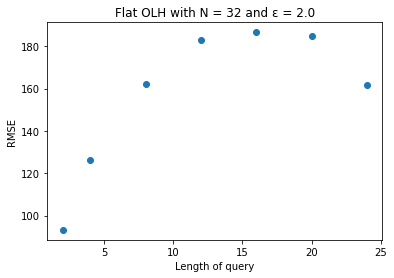

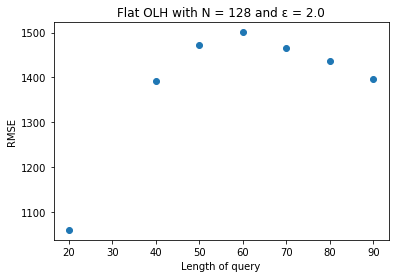

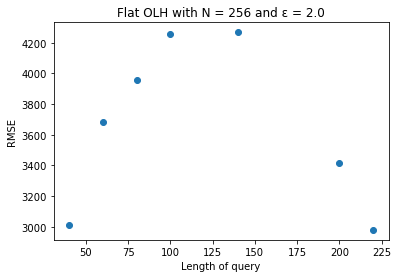

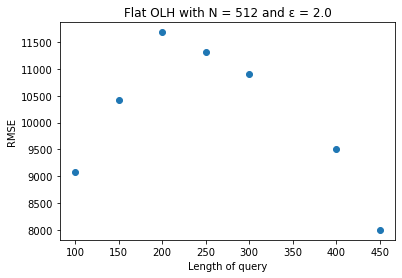

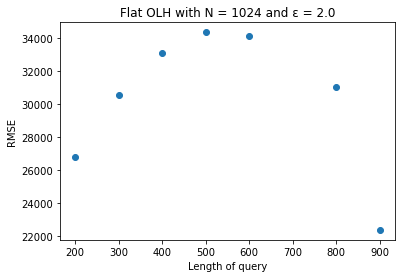

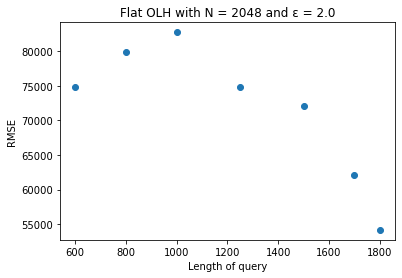

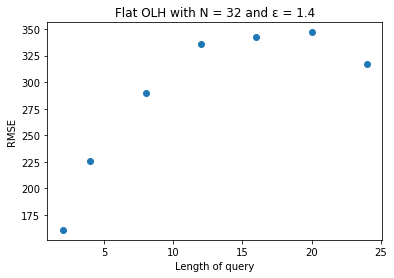

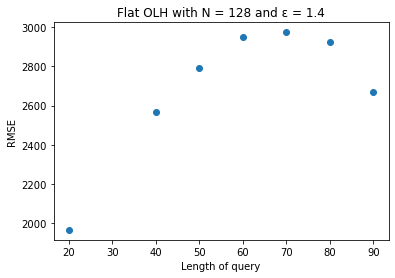

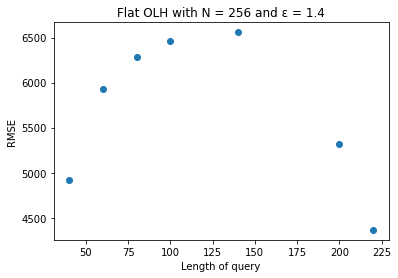

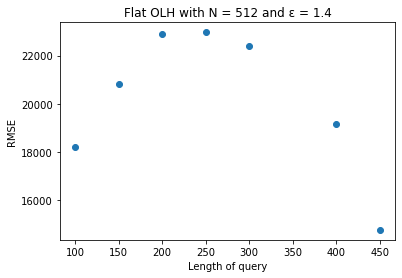

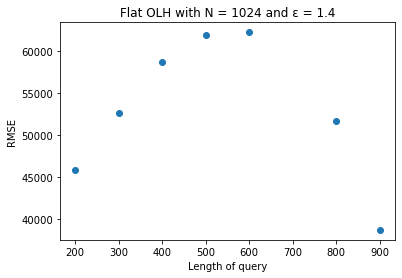

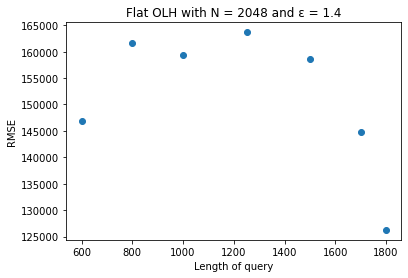

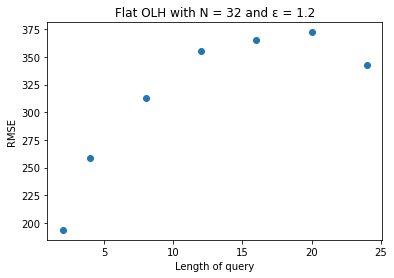

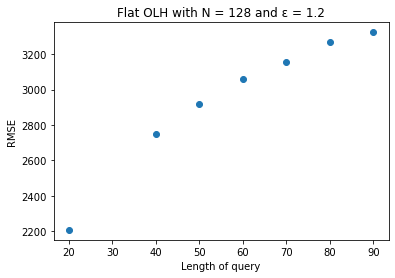

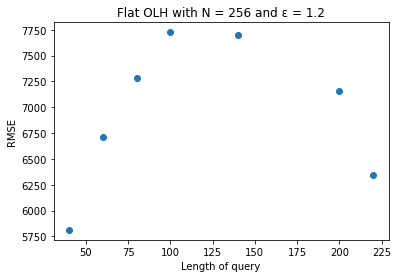

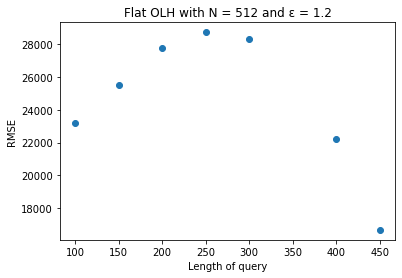

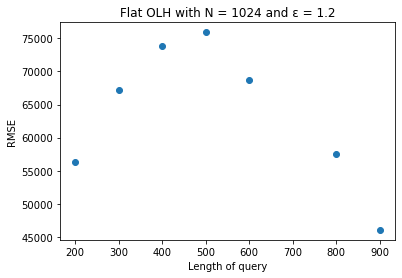

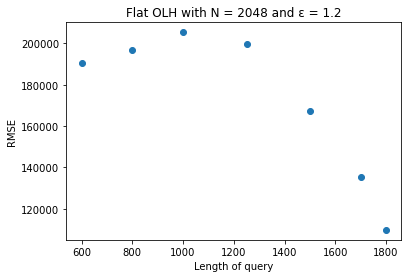

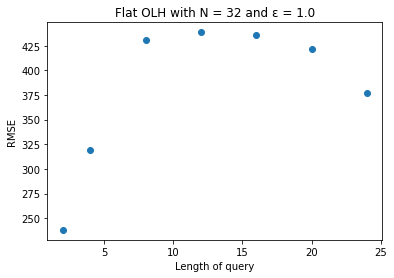

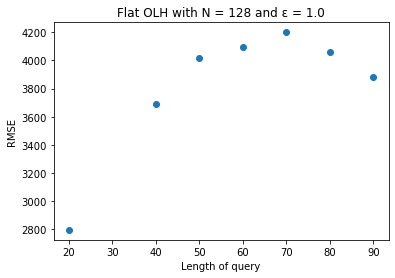

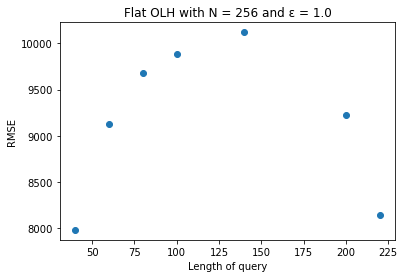

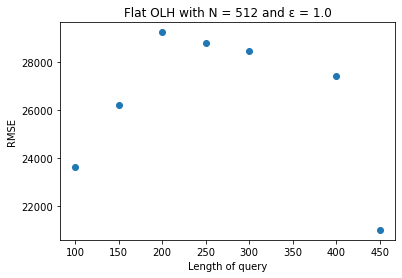

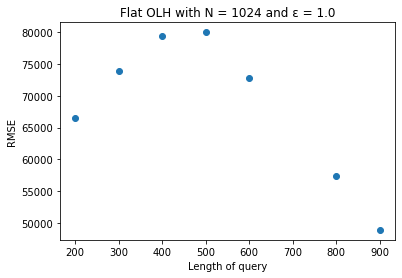

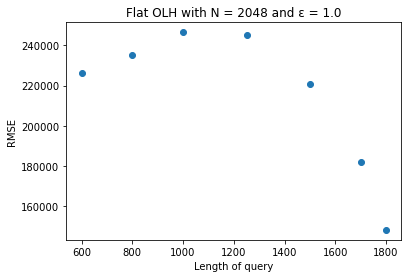

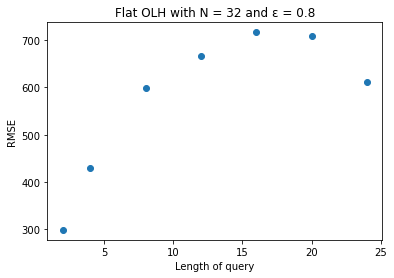

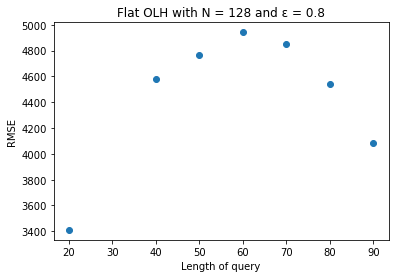

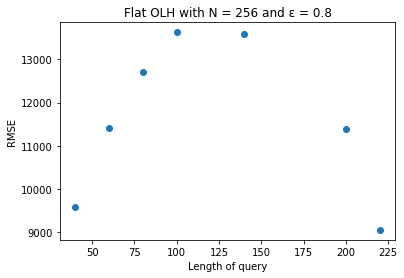

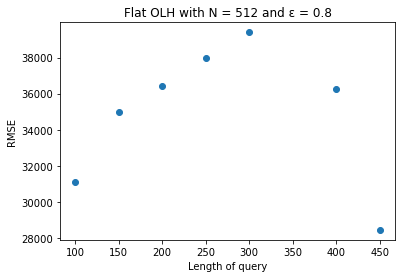

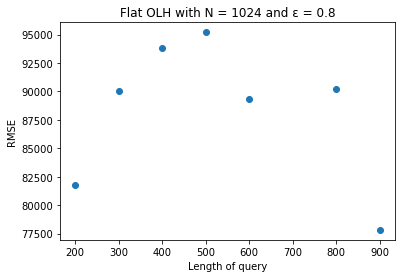

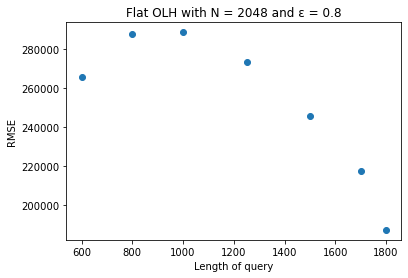

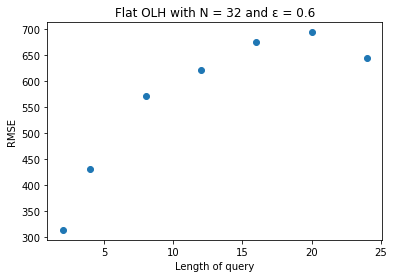

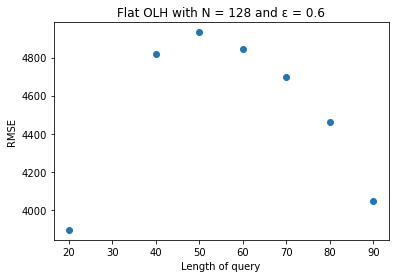

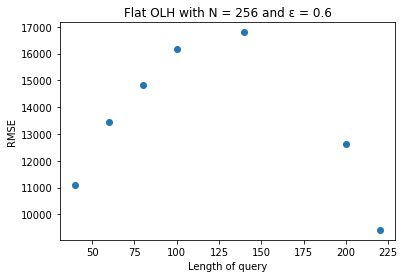

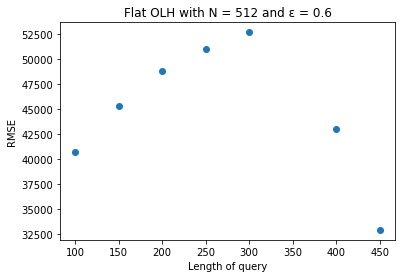

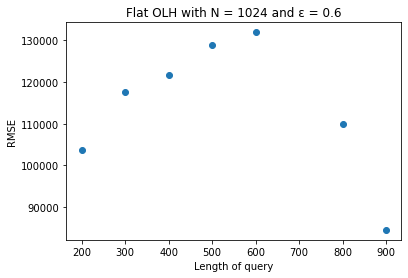

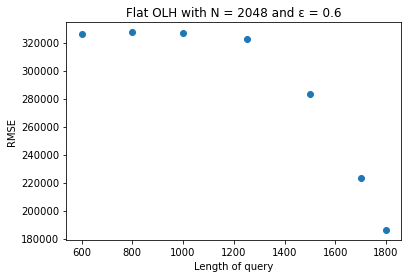

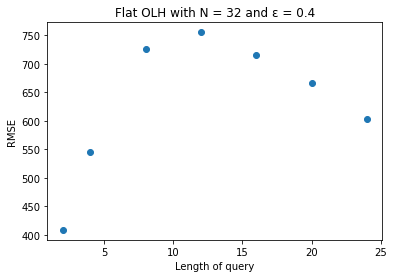

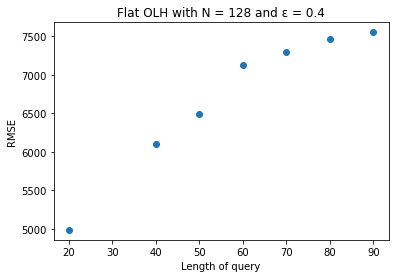

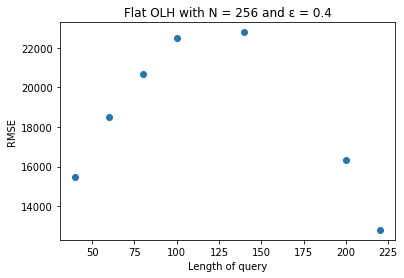

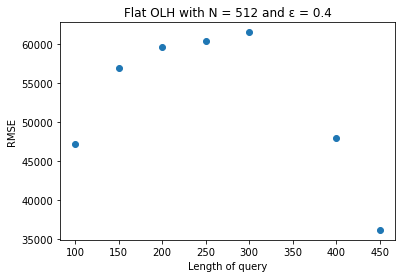

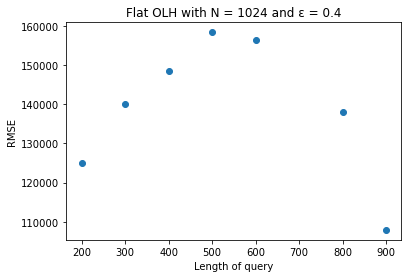

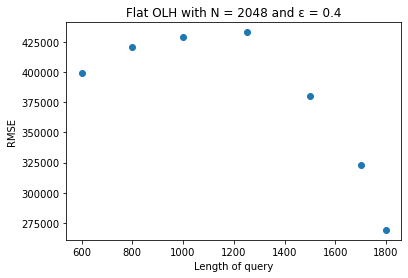

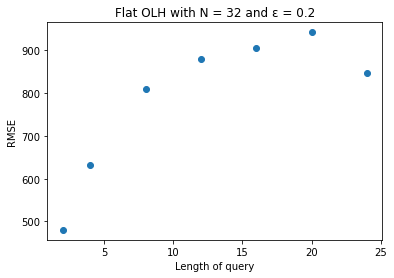

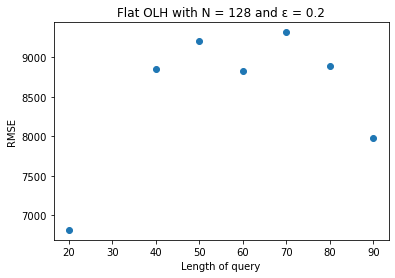

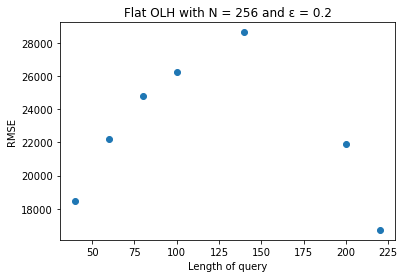

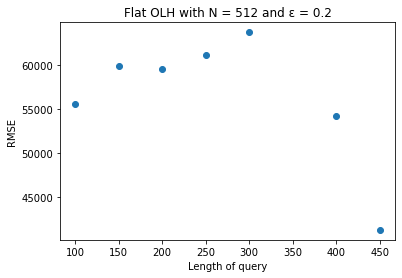

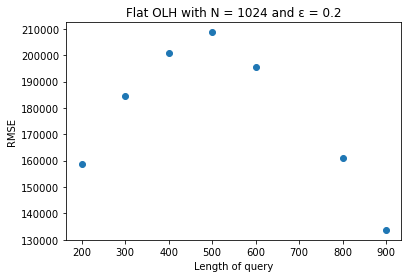

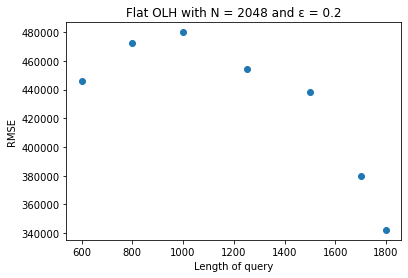

In [17]:
generate_plots(error_dict)


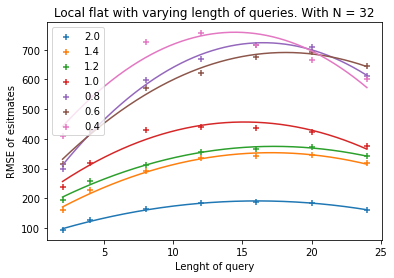

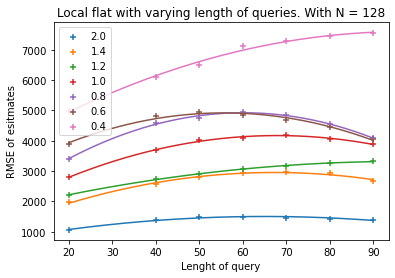

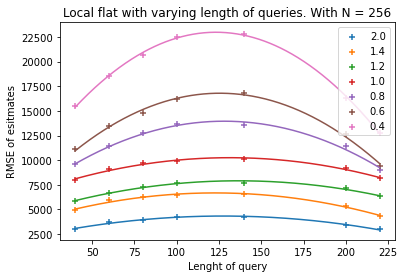

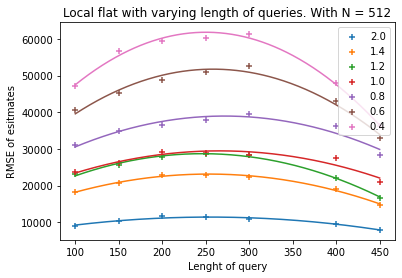

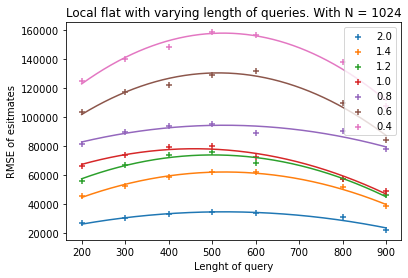

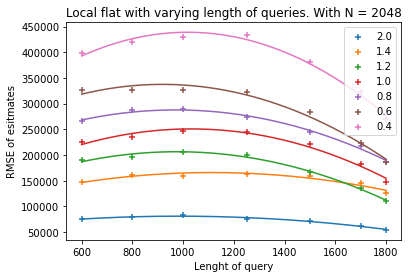

In [32]:
def multi_e_plots(epsilons, n, error_dict, path):
    for N in n:
        rmse_lst = []
        
        for e in epsilons:

            for r_ in error_dict[e][N]:
                rmse = error_dict[e][N][r_]['rmse']
                rmse_lst.append(rmse)
        #print(rmse_lst)
        
        for i in range(len(error_dict[e][N])):
            #print(i)
            #print(list(error_dict[e][N].keys()))
            #print(rmse_lst[i*len(error_dict[e][N]):(i+1)*len(error_dict[e][N])])
            ys = rmse_lst[i*len(error_dict[e][N]):(i+1)*len(error_dict[e][N])]
            xs = list(error_dict[e][N].keys())
            
            mymodel = np.poly1d(np.polyfit(xs, ys, 2))
            mn=np.min(xs)
            mx=np.max(xs)
            x1=np.linspace(mn,mx,500)
            plt.plot(x1, mymodel(x1))

            #plt.scatter(x1, y)
            """
            gradient, intercept, r_value, p_value, std_err = stats.linregress(xs,ys)
            mn=np.min(xs)
            mx=np.max(xs)
            x1=np.linspace(mn,mx,500)
            y1=gradient*x1+intercept
            print(r_value)
            #plt.plot(x,y,'ob')
            plt.plot(x1,y1,'--')
            """
            """
            """
            plt.scatter(xs, ys, marker = '+', label=f"{epsilons[i]}")
        #plt.scatter(epsilons, rmse_degree2, marker = '+', label=f"RMSE of HH esitmates")
        
        #plt.yscale('log')
        plt.legend()
        plt.xlabel('Lenght of query')
        plt.ylabel('RMSE of esitmates')
        plt_name = f'loc_flat_varying_length_N_poly_={N}'
        plt.title(f'Local flat with varying length of queries. With N = {N}')
        plt.savefig(owd + path + plt_name, bbox_inches='tight')
        plt.show()

path = '/plots/local_flat/varying_r/'
multi_e_plots(epsilons, n, error_dict, path)
    
    